In [1]:
import addict
import copy
import gmsh
import meshio
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import celeri

%config InlineBackend.figure_format = "retina"

Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Done meshing 1D (Wall 5.4292e-05s, CPU 4.9e-05s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00186517s, CPU 0.002042s)
Info    : 28 nodes 55 elements
Info    : Writing 'hector_mine_basal.msh'...
Info    : Done writing 'hector_mine_basal.msh'



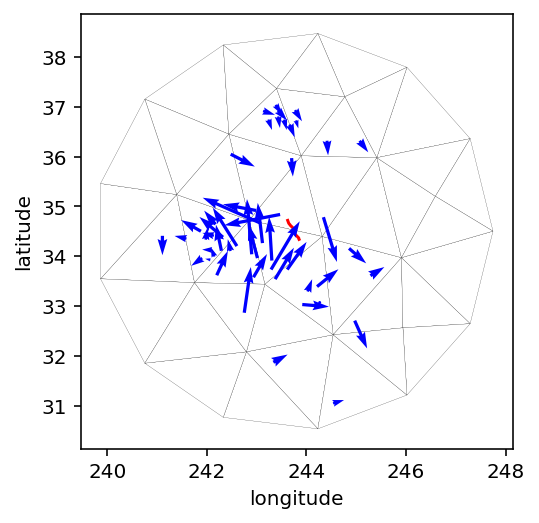

In [2]:
MESH_FILE_NAME = "hector_mine_basal.msh"
GPS_FILE_NAME = "hector_mine_postseismic_gps_freed_burgman_herring.csv"
FAULT_TRACE_FILE_NAME = "hector_mine_fault_trace_from_cfm.csv"

# Read GPS
df_gps = pd.read_csv(GPS_FILE_NAME)

# Remove stations that clearly have longitude reported as northvelocity
df_gps = df_gps[df_gps.north > -100]

# Remove nearfield stations flagged with a trailing asterisk in the original paper
df_gps = df_gps[~df_gps.name.str.contains("\*")]
df_gps.lon = df_gps.lon + 360
df_gps = df_gps.reset_index(drop=True)

# Read fault trace
df_fault = pd.read_csv(FAULT_TRACE_FILE_NAME)
df_fault.lon = df_fault.lon + 360

# Create inital circular mesh
gmsh.initialize()
# Specify x, y, z, radius as first four arguments
gmsh.model.occ.addCircle(0.0, 0.0, 0.0, 4.0, 1, angle1=0.0, angle2=2 * np.pi)
gmsh.model.occ.addCurveLoop([1], 1)
gmsh.model.occ.addPlaneSurface([1], 1)
gmsh.model.occ.synchronize()
# Set the mesh size by changing the 10 (same units as the x, y, z, radius)
gmsh.model.mesh.setSize([(0, 1)], 2)
gmsh.model.mesh.generate(2)
gmsh.write(MESH_FILE_NAME)
gmsh.finalize()

# Read mesh
mesh = meshio.read(MESH_FILE_NAME)
n_tri = mesh.get_cells_type("triangle").shape[0]

# Move mesh to to be centered on the fault
mesh.points[mesh.get_cells_type("triangle")[:, :], 0] += df_fault.lon.mean()
mesh.points[mesh.get_cells_type("triangle")[:, :], 1] += df_fault.lat.mean()

# JPL style slight tilt of z-cordinates
base_depth = 30.0
depth_gradient = 0.000001
mesh.points[mesh.get_cells_type("triangle")[:, :], 2] = base_depth + depth_gradient * (
    mesh.points[mesh.get_cells_type("triangle")[:, :], 0]
    - mesh.points[mesh.get_cells_type("triangle")[:, :], 0].min()
)

# Plot model geometry
plt.figure()
for i in range(0, n_tri):
    plt.fill(
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 0][i],
        ],
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 1][i],
        ],
        "-k",
        facecolor="w",
        edgecolor="k",
        linewidth=0.1,
    )

plt.plot(df_fault.lon, df_fault.lat, "-r")
plt.quiver(df_gps.lon, df_gps.lat, df_gps.east, df_gps.north, color="blue", zorder=10)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.gca().set_aspect("equal")
plt.show()

# Read mesh as a celeri style mesh

In [3]:
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
M2MM = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)


def triangle_normal(triangles):
    # The cross product of two sides is a normal vector
    # https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on
    return np.cross(
        triangles[:, 1] - triangles[:, 0], triangles[:, 2] - triangles[:, 0], axis=1
    )


def triangle_area(triangles):
    # The norm of the cross product of two sides is twice the area
    # https://stackoverflow.com/questions/71346322/numpy-area-of-triangle-and-equation-of-a-plane-on-which-triangle-lies-on
    return np.linalg.norm(triangle_normal(triangles), axis=1) / 2.0


def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z


def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r


# Read mesh data - List of dictionary version
meshes = []
for i in range(1):
    meshes.append(addict.Dict())
    meshes[i].meshio_object = meshio.read(MESH_FILE_NAME)
    meshes[i].file_name = MESH_FILE_NAME
    meshes[i].verts = meshes[i].meshio_object.get_cells_type("triangle")

    # Expand mesh coordinates
    meshes[i].lon1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 0]
    meshes[i].lon2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 0]
    meshes[i].lon3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 0]
    meshes[i].lat1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 1]
    meshes[i].lat2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 1]
    meshes[i].lat3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 1]
    meshes[i].dep1 = meshes[i].meshio_object.points[meshes[i].verts[:, 0], 2]
    meshes[i].dep2 = meshes[i].meshio_object.points[meshes[i].verts[:, 1], 2]
    meshes[i].dep3 = meshes[i].meshio_object.points[meshes[i].verts[:, 2], 2]
    meshes[i].centroids = np.mean(
        meshes[i].meshio_object.points[meshes[i].verts, :], axis=1
    )
    # Cartesian coordinates in meters
    meshes[i].x1, meshes[i].y1, meshes[i].z1 = sph2cart(
        meshes[i].lon1,
        meshes[i].lat1,
        RADIUS_EARTH + KM2M * meshes[i].dep1,
    )
    meshes[i].x2, meshes[i].y2, meshes[i].z2 = sph2cart(
        meshes[i].lon2,
        meshes[i].lat2,
        RADIUS_EARTH + KM2M * meshes[i].dep2,
    )
    meshes[i].x3, meshes[i].y3, meshes[i].z3 = sph2cart(
        meshes[i].lon3,
        meshes[i].lat3,
        RADIUS_EARTH + KM2M * meshes[i].dep3,
    )

    # Cartesian triangle centroids
    meshes[i].x_centroid = (meshes[i].x1 + meshes[i].x2 + meshes[i].x3) / 3.0
    meshes[i].y_centroid = (meshes[i].y1 + meshes[i].y2 + meshes[i].y3) / 3.0
    meshes[i].z_centroid = (meshes[i].z1 + meshes[i].z2 + meshes[i].z3) / 3.0

    # Cross products for orientations
    tri_leg1 = np.transpose(
        [
            np.deg2rad(meshes[i].lon2 - meshes[i].lon1),
            np.deg2rad(meshes[i].lat2 - meshes[i].lat1),
            (1 + KM2M * meshes[i].dep2 / RADIUS_EARTH)
            - (1 + KM2M * meshes[i].dep1 / RADIUS_EARTH),
        ]
    )
    tri_leg2 = np.transpose(
        [
            np.deg2rad(meshes[i].lon3 - meshes[i].lon1),
            np.deg2rad(meshes[i].lat3 - meshes[i].lat1),
            (1 + KM2M * meshes[i].dep3 / RADIUS_EARTH)
            - (1 + KM2M * meshes[i].dep1 / RADIUS_EARTH),
        ]
    )
    meshes[i].nv = np.cross(tri_leg1, tri_leg2)
    azimuth, elevation, r = cart2sph(
        meshes[i].nv[:, 0],
        meshes[i].nv[:, 1],
        meshes[i].nv[:, 2],
    )
    meshes[i].strike = celeri.wrap2360(-np.rad2deg(azimuth))
    meshes[i].dip = 90 - np.rad2deg(elevation)
    meshes[i].dip_flag = meshes[i].dip != 90
    # meshes[i].smoothing_weight = mesh_param[i]["smoothing_weight"]
    # meshes[i].n_eigen = mesh_param[i]["n_eigen"]
    # meshes[i].top_slip_rate_constraint = mesh_param[i]["top_slip_rate_constraint"]
    # meshes[i].bot_slip_rate_constraint = mesh_param[i]["bot_slip_rate_constraint"]
    # meshes[i].side_slip_rate_constraint = mesh_param[i]["side_slip_rate_constraint"]
    meshes[i].n_tde = meshes[i].lon1.size

    # Calcuate areas of each triangle in mesh
    triangle_vertex_array = np.zeros((meshes[i].n_tde, 3, 3))
    triangle_vertex_array[:, 0, 0] = meshes[i].x1
    triangle_vertex_array[:, 1, 0] = meshes[i].x2
    triangle_vertex_array[:, 2, 0] = meshes[i].x3
    triangle_vertex_array[:, 0, 1] = meshes[i].y1
    triangle_vertex_array[:, 1, 1] = meshes[i].y2
    triangle_vertex_array[:, 2, 1] = meshes[i].y3
    triangle_vertex_array[:, 0, 2] = meshes[i].z1
    triangle_vertex_array[:, 1, 2] = meshes[i].z2
    triangle_vertex_array[:, 2, 2] = meshes[i].z3
    meshes[i].areas = triangle_area(triangle_vertex_array)
    celeri.get_mesh_edge_elements(meshes)

celeri.get_mesh_perimeter(meshes)

# Calculate partial derivatives

In [4]:
operators = addict.Dict()

material_lambda = 3e10
material_mu = 3e10
tri_operator = np.zeros((3 * len(df_gps), 3 * n_tri))

# Loop through each segment and calculate displacements for each slip component
for i in tqdm(
    range(n_tri),
    desc="Calculating cutde partials for triangles",
    colour="green",
):
    (
        vel_east_strike_slip,
        vel_north_strike_slip,
        vel_up_strike_slip,
    ) = celeri.get_tri_displacements(
        df_gps.lon.to_numpy(),
        df_gps.lat.to_numpy(),
        meshes,
        material_lambda,
        material_mu,
        tri_idx=i,
        strike_slip=1,
        dip_slip=0,
        tensile_slip=0,
    )
    (
        vel_east_dip_slip,
        vel_north_dip_slip,
        vel_up_dip_slip,
    ) = celeri.get_tri_displacements(
        df_gps.lon.to_numpy(),
        df_gps.lat.to_numpy(),
        meshes,
        material_lambda,
        material_mu,
        tri_idx=i,
        strike_slip=0,
        dip_slip=1,
        tensile_slip=0,
    )
    (
        vel_east_tensile_slip,
        vel_north_tensile_slip,
        vel_up_tensile_slip,
    ) = celeri.get_tri_displacements(
        df_gps.lon.to_numpy(),
        df_gps.lat.to_numpy(),
        meshes,
        material_lambda,
        material_mu,
        tri_idx=i,
        strike_slip=0,
        dip_slip=0,
        tensile_slip=1,
    )
    tri_operator[0::3, 3 * i] = np.squeeze(vel_east_strike_slip)
    tri_operator[1::3, 3 * i] = np.squeeze(vel_north_strike_slip)
    tri_operator[2::3, 3 * i] = np.squeeze(vel_up_strike_slip)
    tri_operator[0::3, 3 * i + 1] = np.squeeze(vel_east_dip_slip)
    tri_operator[1::3, 3 * i + 1] = np.squeeze(vel_north_dip_slip)
    tri_operator[2::3, 3 * i + 1] = np.squeeze(vel_up_dip_slip)
    tri_operator[0::3, 3 * i + 2] = np.squeeze(vel_east_tensile_slip)
    tri_operator[1::3, 3 * i + 2] = np.squeeze(vel_north_tensile_slip)
    tri_operator[2::3, 3 * i + 2] = np.squeeze(vel_up_tensile_slip)


# # operators.tri_station = celeri.get_tri_station_operator_okada(meshes, station, command)
# operators.tri_station = celeri.get_tde_to_velocities(meshes, station, command)
# celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# # Eliminate matrix entries for vertical displacments and tensile slip
tde_matrix = copy.deepcopy(tri_operator)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

Calculating cutde partials for triangles: 100%|██████████| 41/41 [00:00<00:00, 760.13it/s]


# Create smoothing matrix

In [5]:
tde_matrix.shape

(100, 82)

# Solve the linear system for basal slip

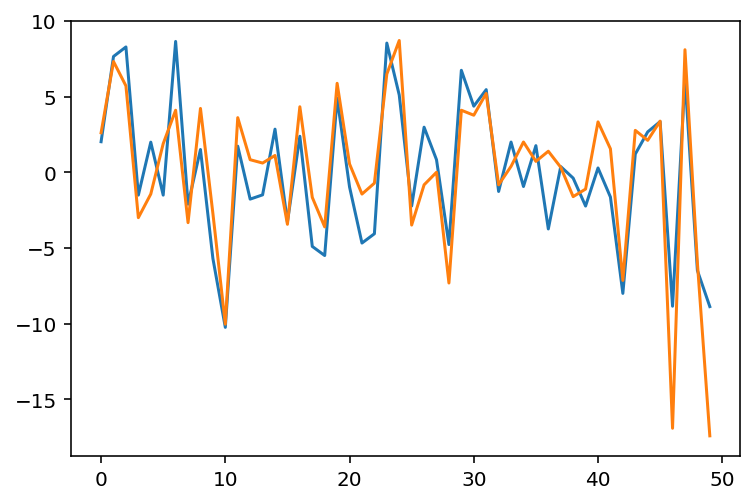

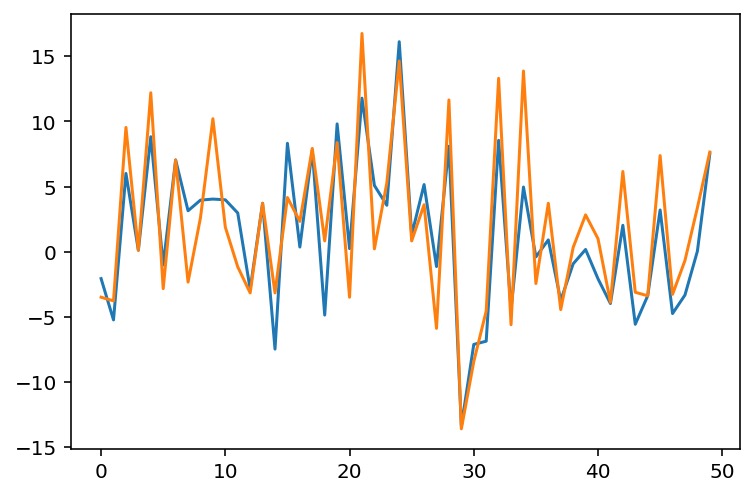

In [8]:
data_vector = np.zeros(2 * len(df_gps))
data_vector[0::2] = df_gps.east.to_numpy()
data_vector[1::2] = df_gps.north.to_numpy()
state_vector = np.linalg.inv(tde_matrix.T @ tde_matrix) @ tde_matrix.T @ data_vector
# state_vector = tde_matrix.T @ np.linalg.inv(tde_matrix @ tde_matrix.T) @ data_vector


predicted_data_vector = tde_matrix @ state_vector
predicted_east = predicted_data_vector[0::2]
predicted_north = predicted_data_vector[1::2]

plt.figure()
plt.plot(predicted_east)
plt.plot(df_gps.east)
plt.show()

plt.figure()
plt.plot(predicted_north)
plt.plot(df_gps.north)
plt.show()

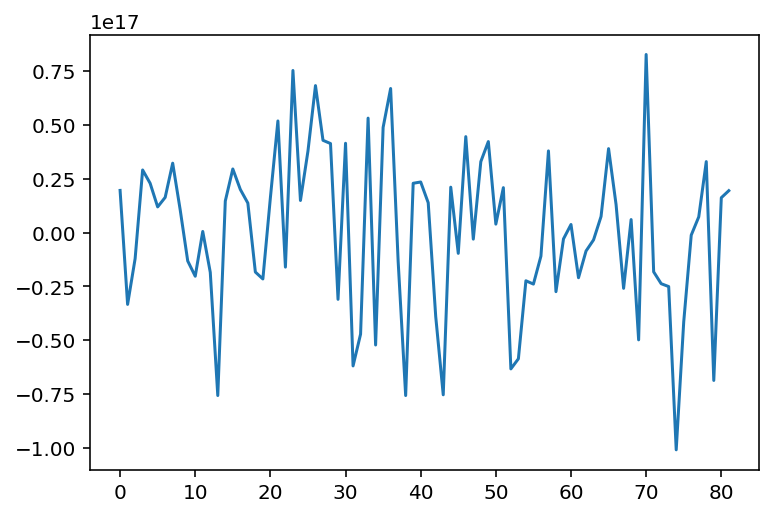

In [9]:
plt.plot(state_vector)